# Explore here

### Paso 1: Planteamiento del problema y recopilación de datos:


**Datos socio demográficos y de recursos de salud a nivel de condado de EE. UU. (2018-2019)**

Se han recopilado datos socio demográficos y de recursos de salud por condado en los Estados Unidos y queremos descubrir si existe alguna relación entre los recursos sanitarios y los datos socio demográficos.

In [2]:
pip install openpyxl


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import json
from numpy._core.defchararray import upper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



In [4]:
url = "https://breathecode.herokuapp.com/asset/internal-link?id=733&path=demographic_health_data.csv"
total_data = pd.read_csv(url)
total_data.head()

fips  TOT_POP    0-9  0-9 y/o % of total pop  19-Oct  \
0  1001    55601   6787               12.206615    7637   
1  1003   218022  24757               11.355276   26913   
2  1005    24881   2732               10.980266    2960   
3  1007    22400   2456               10.964286    2596   
4  1009    57840   7095               12.266598    7570   

   10-19 y/o % of total pop  20-29  20-29 y/o % of total pop  30-39  \
0                 13.735364   6878                 12.370281   7089   
1                 12.344167  23579                 10.814964  25213   
2                 11.896628   3268                 13.134520   3201   
3                 11.589286   3029                 13.522321   3113   
4                 13.087828   6742                 11.656293   6884   

   30-39 y/o % of total pop  ...  COPD_number  diabetes_prevalence  \
0                 12.749771  ...         3644                 12.9   
1                 11.564429  ...        14692                 12.0   
2                 12.865239  ...         2373                 19.7   
3                 13.897321  ...         1789                 14.1   
4                 11.901798  ...         4661                 13.5   

   diabetes_Lower 95% CI  diabetes_Upper 95% CI  diabetes_number  \
0                   11.9                   13.8             5462   
1                   11.0                   13.1            20520   
2                   18.6                   20.6             3870   
3                   13.2                   14.9             2511   
4                   12.6                   14.5             6017   

   CKD_prevalence  CKD_Lower 95% CI  CKD_Upper 95% CI  CKD_number  \
0             3.1               2.9               3.3        1326   
1             3.2               3.0               3.5        5479   
2             4.5               4.2               4.8         887   
3             3.3               3.1               3.6         595   
4             3.4               3.2               3.7        1507   

   Urban_rural_code  
0                 3  
1                 4  
2                 6  
3                 2  
4                 2  

[5 rows x 108 columns]

### Paso 2: Exploración y limpieza de datos:

Hay que conocer las dimensiones y tipologías de datos del objeto con el que estamos trabajando es vital. Para ello necesitamos el atributo shape para obtener las dimensiones del objeto y la función info() para conocer la tipología y la cantidad de valores no nulos:

In [5]:
#Conocer las dimensiones
total_data.shape
print(f"Hay {total_data.shape[0]} filas y {total_data.shape[1]} columnas")

Hay 3140 filas y 108 columnas


In [6]:
# Obtener información sobre tipos de datos y valores no nulos
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [7]:
vars_numericas = total_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
vars_categoricas = total_data.select_dtypes(include=["object"]).columns.tolist()
print(vars_categoricas,vars_numericas)

['COUNTY_NAME', 'STATE_NAME'] ['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018', 'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2018', 'Less than a high school diploma 2014-18', 'High school diploma only 2014-18', "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18

Como podemos obersvar, hay 2 variables categóricas y el resto son numéricas. Además tomamos como target la variable de problemas de corazón

**Eliminación de duplicados**

In [8]:
num_duplicates = total_data.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

if num_duplicates > 0:
    total_data = total_data.drop_duplicates().reset_index(drop = True)
    print(f"Número duplicados borrados. Ahora hay {total_data.shape[0]} datos")
else:
    print("No se han encontrado duplicados")

Número de filas duplicadas: 0
No se han encontrado duplicados


### Paso 3: Análisis de variables univariante:

Una variable univariante es un término estadístico que se emplea para referenciar un conjunto de observaciones de un atributo. Esto es, el análisis columna a columna del DataFrame. Para ello, debemos distinguir si una variable es categórica o numérica, ya que el cuerpo del análisis y las conclusiones que se pueden obtener serán distintas.

**Análisis sobre variables categóricas:**

Una variable categórica es un tipo de variable que puede tomar uno de un número limitado de categorías o grupos. Estos grupos son a menudo nominales (por ejemplo, el color de un coche: rojo, azul, negro, etc, pero ninguno de estos colores es inherentemente "mayor" o "mejor" que los demás) pero pueden también representarse mediante números finitos.

Para representar este tipo de variables utilizaremos histogramas.

Las variables categóricas son ['COUNTY_NAME', 'STATE_NAME']


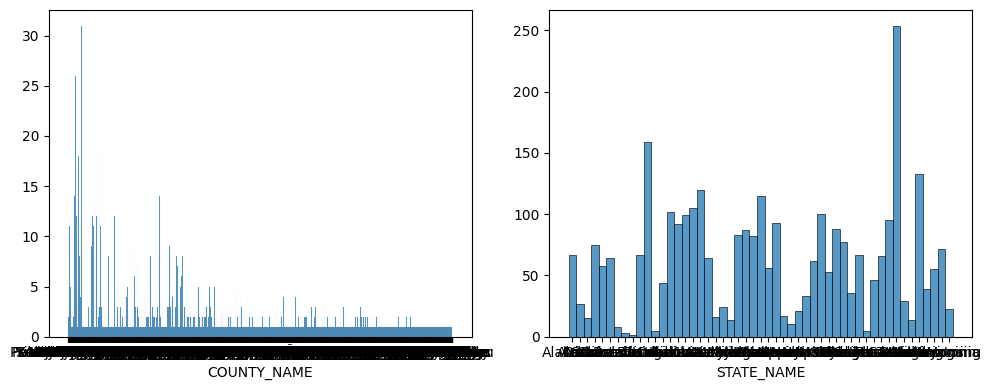

In [9]:
print(f"Las variables categóricas son {vars_categoricas}")


n_cols = 3
n_rows = math.ceil(len(vars_categoricas) / n_cols)

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

for i, col in enumerate(vars_categoricas):
    sns.histplot(ax=axis[i],data=total_data,x=col).set_ylabel(None)
    
for j in range(i + 1, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

Hay muchos segmentos para poder analizar con detalle los datos

**Análisis sobre variables numéricas:**

Una variable numérica es un tipo de variable que puede tomar valores numéricos (enteros, fracciones, decimales, negativos, etc.) en un rango infinito. Una variable categórica numérica puede ser también una variable numérica (por ejemplo, para los sucesivos análisis, podemos tomar la clase Survived como numérica también para estudiar relaciones). Normalmente se representan utilizando un histograma y diagramas de caja, expuestos juntos.

Las variables numéricas son ['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018', 'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2018', 'Less than a high school diploma 2014-18', 'High school diploma only 2014-18', "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18",

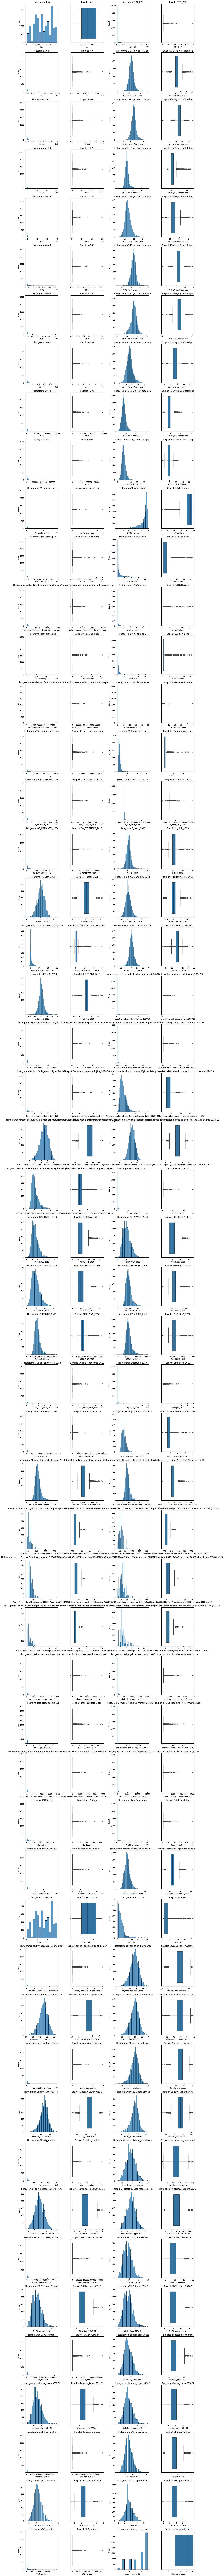

In [10]:
print(f"Las variables numéricas son {vars_numericas}")

n_cols = 4
n_rows = 2*(math.ceil(len(vars_numericas) / n_cols))

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axis = axis.flatten()

for i, col in enumerate(vars_numericas):
    sns.histplot(data=total_data, x=col, ax=axis[2*i])
    axis[2*i].set_title(f"Histograma {col}")

    sns.boxplot(data=total_data, x=col, ax=axis[2*i + 1])
    axis[2*i + 1].set_title(f"Boxplot {col}")

# Eliminar subplots sobrantes
for j in range(2*i + 2, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

**Análisis numérico-numérico:**

Cuando las dos variables que se comparan tienen datos numéricos, se dice que el análisis es numérico-numérico. Para comparar dos columnas numéricas se utilizan diagramas de dispersión y análisis de correlaciones.

In [11]:
target="Heart disease_number"
vars_num_sin_pred=[col for col in vars_numericas if col != target]

/tmp/ipykernel_9546/3110089103.py:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


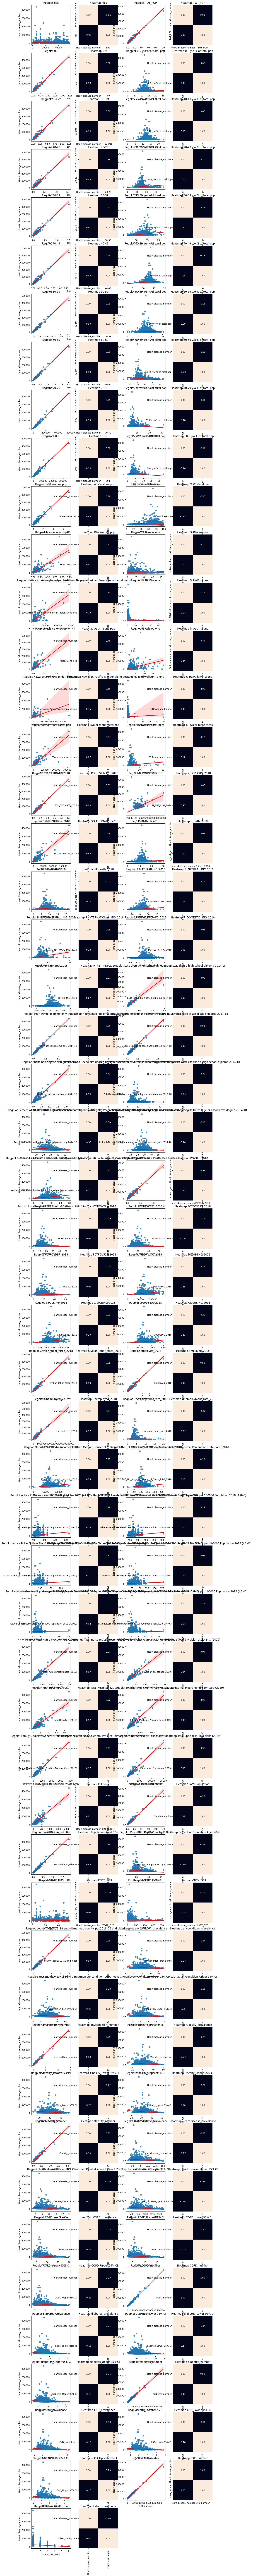

In [12]:
n_cols = 4

n_rows =2*( math.ceil(len(vars_num_sin_pred) / n_cols))

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axis = axis.flatten()
for i, col in enumerate(vars_num_sin_pred):
    sns.regplot(ax = axis[2*i], data = total_data, x = col, y = target,line_kws={"color": "red"})
    axis[2*i].set_title(f"Regplot {col}")
    sns.heatmap(total_data[[target,col]].corr(), annot = True, fmt = ".2f", ax = axis[2*i + 1], cbar = False)
    axis[2*i + 1].set_title(f"Heatmap {col}")

# Eliminar subplots sobrantes
for j in range(2*i + 2, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

In [13]:
correlaciones = {}

for col in vars_num_sin_pred:
    corr = total_data[col].corr(total_data[target], method="pearson")
    correlaciones[col] = corr


correlaciones_ordenadas = { col: corr for col, corr in sorted(correlaciones.items(), key=lambda item: abs(item[1]), reverse=True)}

for col, corr in correlaciones_ordenadas.items():
    print(f"Correlación entre {col} y {target}: {corr:.3f}")


Correlación entre COPD_number y Heart disease_number: 0.997
Correlación entre CKD_number y Heart disease_number: 0.995
Correlación entre anycondition_number y Heart disease_number: 0.993
Correlación entre 60-69 y Heart disease_number: 0.992
Correlación entre High school diploma only 2014-18 y Heart disease_number: 0.991
Correlación entre Population Aged 60+ y Heart disease_number: 0.991
Correlación entre 70-79 y Heart disease_number: 0.990
Correlación entre diabetes_number y Heart disease_number: 0.990
Correlación entre Obesity_number y Heart disease_number: 0.989
Correlación entre county_pop2018_18 and older y Heart disease_number: 0.988
Correlación entre TOT_POP y Heart disease_number: 0.988
Correlación entre POP_ESTIMATE_2018 y Heart disease_number: 0.988
Correlación entre 50-59 y Heart disease_number: 0.987
Correlación entre Total Population y Heart disease_number: 0.987
Correlación entre Some college or associate's degree 2014-18 y Heart disease_number: 0.986
Correlación entre Civ

Hay variables muy correlacionadas con la target. Esperemos al heatmap para verlo con más detalle

**Análisis categórico-categórico**

Cuando las dos variables que se comparan tienen datos categóricos, se dice que el análisis es categórico-categórico. Para comparar dos columnas categóricas se utilizan histogramas y combinaciones.

In [14]:
vars_categoricas_n=[]
for col in vars_categoricas:
    total_data[f"{col}_n"] = pd.factorize(total_data[col])[0]
    vars_categoricas_n.append(f"{col}_n")
    

for col in vars_categoricas:
    transformation_rules = {row[f"{col}"]: row[f"{col}_n"]
    for _, row in total_data[[f"{col}_n", col]].drop_duplicates().iterrows()}

    nombrearchivo = f"./{col}_transformation_rules.json"
    with open(nombrearchivo,"w") as f:
        json.dump(transformation_rules, f)

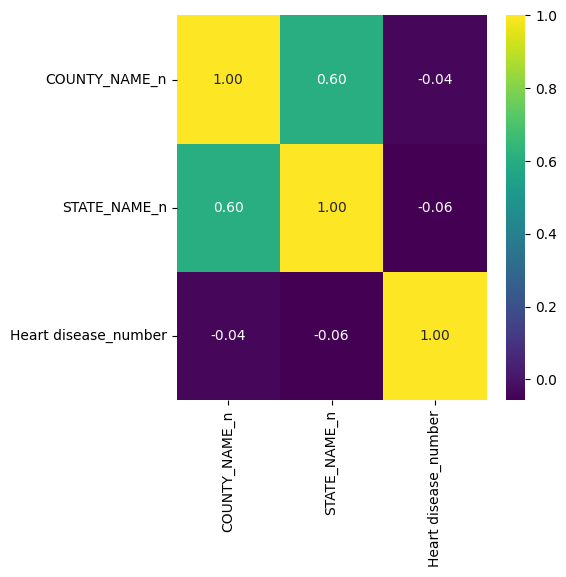

In [15]:
vars_final=vars_categoricas_n+vars_numericas
total_data=total_data[vars_final]
vars_heatmap=vars_categoricas_n+[target]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(total_data[vars_heatmap].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.show()

No estan muy relacionadas con la target

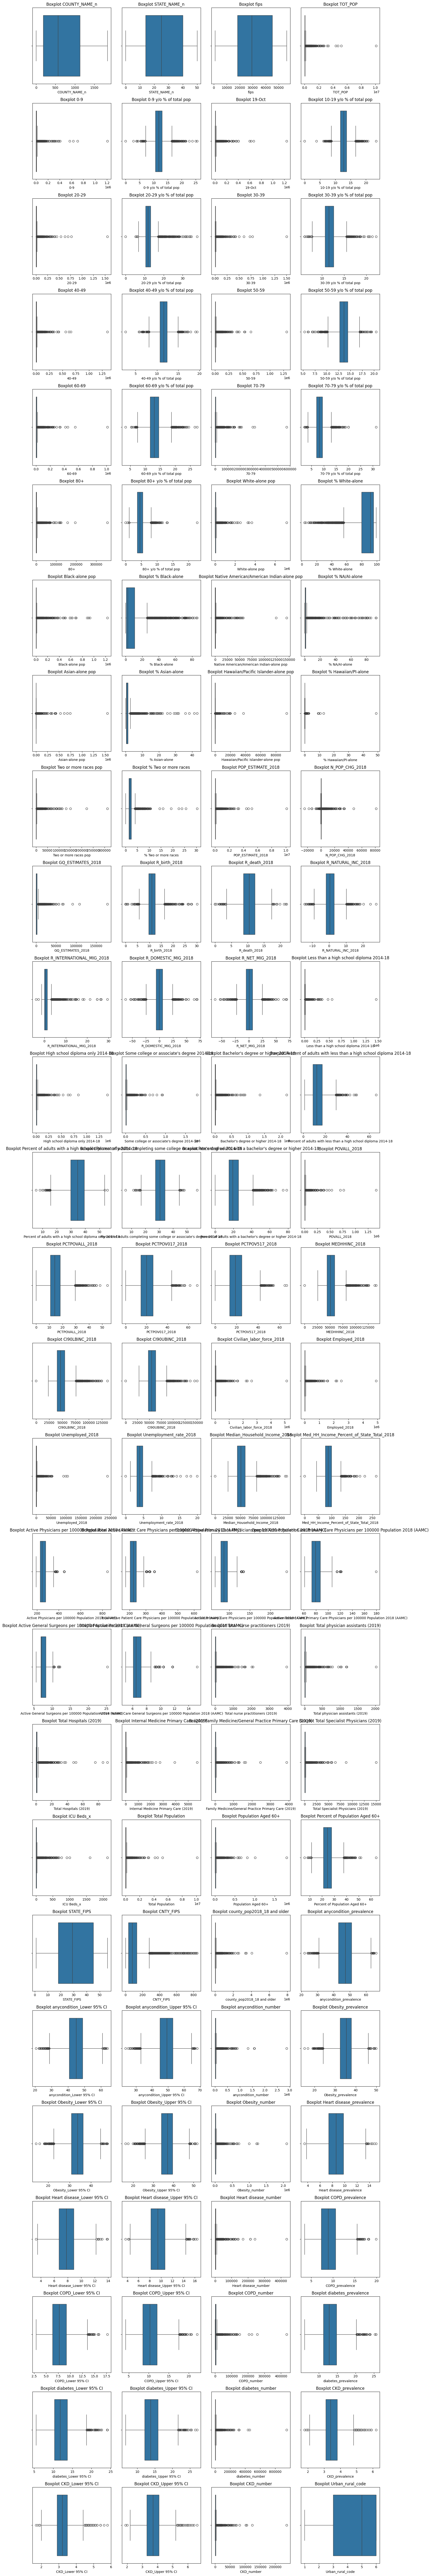

In [16]:
n_cols = 4
n_rows = math.ceil(len(vars_final) / n_cols)

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axis = axis.flatten()

for i, col in enumerate(vars_final):
    sns.boxplot(data=total_data, x=col, ax=axis[i])
    axis[i].set_title(f"Boxplot {col}")

plt.tight_layout()
plt.show()

In [17]:
# TENEMOS QUE GUARDARNOS TODOS LOS DATASETS, ES DECIR:

total_data_CON_outliers = total_data.copy()
total_data_SIN_outliers = total_data.copy() # Lo vamos a modificar. Para cada variable con outliers, reemplazamos sus valores outliers
outliers_cols = []

for col in total_data:
    Q1 = total_data[col].quantile(0.25)
    Q3 = total_data[col].quantile(0.75)
    IQR = Q3 - Q1
    abajo = Q1 - 1.5 * IQR
    arriba = Q3 + 1.5 * IQR
    outliers = total_data[(total_data[col] < abajo) | (total_data[col] > arriba)]
    if not outliers.empty:
        outliers_cols.append(col)



def replace_outliers(column, df):
  col_stats = total_data[column].describe()
  col_iqr = col_stats["75%"] - col_stats["25%"]
  upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
  lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

  if lower_limit < 0: lower_limit = min(df[column])
  # Vamos a quitar los outliers superiores
  df[column] = df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  # Vamos a quitar los outliers inferiores
  df[column] = df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  return df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in outliers_cols:
  total_data_SIN_outliers, limits = replace_outliers(column, total_data_SIN_outliers)
  outliers_dict.update({column: limits})

outliers_dict # Este JSON me lo tengo que GUARDAR
with open("./outliers_dict.json", "w") as f:
  json.dump(outliers_dict, f)

In [18]:
outliers_cols

['TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '19-Oct',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 20

**Análisis de valores faltantes**

Un valor faltante (missing value) es un espacio que no tiene valor asignado en la observación de una variable específica. Este tipo de valores son bastante comunes y pueden surgir por muchas razones. Por ejemplo, podría haber un error en la recopilación de datos, alguien podría haberse negado a responder una pregunta en una encuesta, o simplemente podría ser que cierta información no esté disponible o no sea aplicable.

La función isnull() es una poderosa herramienta para obtener esta información:

In [19]:
total_data_CON_outliers.isnull().sum().sort_values(ascending=False)

COUNTY_NAME_n       0
STATE_NAME_n        0
fips                0
TOT_POP             0
0-9                 0
                   ..
CKD_prevalence      0
CKD_Lower 95% CI    0
CKD_Upper 95% CI    0
CKD_number          0
Urban_rural_code    0
Length: 108, dtype: int64

No hay nulos en ninguna de los data sets

## Paso 5.5: Aplicación

El *escalado de valores* (*feature scaling*) es un paso crucial en el preprocesamiento de datos para muchos algoritmos de Machine Learning. Es una técnica que cambia el rango de los valores de los datos para que puedan ser comparables entre sí. El escalado normalmente implica la normalización, que es el proceso de cambiar los valores para que tengan una media de 0 y una desviación estándar de 1. Otra técnica común es el escalado mínimo-máximo, que transforma los datos para que todos los valores estén entre 0 y 1.

Antes de escalar los valores, debemos asegurarnos de que todas nuestras variables predictoras sean numéricas. Una vez preparadas, podemos aplicar técnicas como la normalización o el escalado Min-Max directamente sobre el dataset completo. Más adelante, cuando pasemos a la fase de modelado, será el momento de dividir los datos en entrenamiento y prueba.

In [20]:
predictoras=[col for col in total_data if col!=target]


In [21]:
# total_data_SIN_outliers
# total_data_CON_outliers
X_CON = total_data_CON_outliers.drop(target, axis = 1)[predictoras]
X_SIN = total_data_SIN_outliers.drop(target, axis = 1)[predictoras]
y = total_data_CON_outliers[target]

X_train_CON_outliers, X_test_CON_outliers, y_train, y_test = train_test_split(X_CON, y, test_size = 0.2, random_state = 10)
X_train_SIN_outliers, X_test_SIN_outliers = train_test_split(X_SIN, test_size = 0.2, random_state = 10)


In [22]:
# X_train_CON_outliers
# X_train_SIN_outliers

# X_test_CON_outliers
# X_test_SIN_outliers

# TENGO QUE GUARDARME TRES SITUACIONES: 1) DATASET SIN TOCAR, 2) DATASET NORMALIZADO, 3) DATASET MIN-MAX

## NORMALIZACIÓN
### CON OUTLIERS
norm_CON_outliers = StandardScaler()
norm_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_norm = norm_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_norm = pd.DataFrame(X_train_CON_outliers_norm, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_norm = norm_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_norm = pd.DataFrame(X_test_CON_outliers_norm, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
norm_SIN_outliers = StandardScaler()
norm_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_norm = norm_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_norm = pd.DataFrame(X_train_SIN_outliers_norm, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_norm = norm_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_norm = pd.DataFrame(X_test_SIN_outliers_norm, index = X_test_SIN_outliers.index, columns = predictoras)


## ESCALADO MIN-MAX (MINMAXIMIZACIÓN)
### CON OUTLIERS
scaler_CON_outliers = MinMaxScaler()
scaler_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_scal = scaler_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_scal = pd.DataFrame(X_train_CON_outliers_scal, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_scal = scaler_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_scal = pd.DataFrame(X_test_CON_outliers_scal, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
scaler_SIN_outliers = MinMaxScaler()
scaler_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_scal = scaler_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_scal = pd.DataFrame(X_train_SIN_outliers_scal, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_scal = scaler_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_scal = pd.DataFrame(X_test_SIN_outliers_scal, index = X_test_SIN_outliers.index, columns = predictoras)

# X_train_CON_outliers
# X_train_CON_outliers_norm
# X_train_CON_outliers_scal
# X_train_SIN_outliers
# X_train_SIN_outliers_norm
# X_train_SIN_outliers_scal

# X_test_CON_outliers
# X_test_CON_outliers_norm
# X_test_CON_outliers_scal
# X_test_SIN_outliers
# X_test_SIN_outliers_norm
# X_test_SIN_outliers_scal

In [24]:
# DATASETS QUE HE IDO ACUMULANDO EN LOS PASOS 4 Y 5
X_train_CON_outliers.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_train_CON_outliers.xlsx", index = False)
X_train_CON_outliers_norm.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_train_CON_outliers_norm.xlsx", index = False)
X_train_CON_outliers_scal.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_train_CON_outliers_scal.xlsx", index = False)
X_train_SIN_outliers.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_train_SIN_outliers.xlsx", index = False)
X_train_SIN_outliers_norm.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_train_SIN_outliers_norm.xlsx", index = False)
X_train_SIN_outliers_scal.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_train_SIN_outliers_scal.xlsx", index = False)

X_test_CON_outliers.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_test_CON_outliers.xlsx", index = False)
X_test_CON_outliers_norm.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_test_CON_outliers_norm.xlsx", index = False)
X_test_CON_outliers_scal.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_test_CON_outliers_scal.xlsx", index = False)
X_test_SIN_outliers.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_test_SIN_outliers.xlsx", index = False)
X_test_SIN_outliers_norm.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_test_SIN_outliers_norm.xlsx", index = False)
X_test_SIN_outliers_scal.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/X_test_SIN_outliers_scal.xlsx", index = False)

y_train.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/y_train.xlsx", index = False)
y_test.to_excel("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/data/processed/y_test.xlsx", index = False)

# SCALERS


with open("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/models/norm_CON_outliers.pkl", "wb") as file:
  pickle.dump(norm_CON_outliers, file)
with open("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/models/norm_SIN_outliers.pkl", "wb") as file:
  pickle.dump(norm_SIN_outliers, file)
with open("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/models/scaler_CON_outliers.pkl", "wb") as file:
  pickle.dump(scaler_CON_outliers, file)
with open("/workspaces/machine-learning-python-template4-JohnnyXavierReyesBorbor/models/scaler_SIN_outliers.pkl", "wb") as file:
  pickle.dump(scaler_SIN_outliers, file)

## Paso 6: Selección de características

La *selección de características* (*feature selection*) es un proceso que implica seleccionar las características (variables) más relevantes de nuestro conjunto de datos para usarlas en la construcción de un modelo de Machine Learning, desechando el resto.

Existen varias razones para incluirlo en nuestro análisis exploratorio:

1. Simplificar el modelo para que sea más fácil de entender e interpretar.
2. Reducir el tiempo de entrenamiento del modelo.
3. Evitar el sobre ajuste al reducir la dimensionalidad del modelo y minimizar el ruido y las correlaciones innecesarias.
4. Mejorar el rendimiento del modelo al eliminar las características irrelevantes.

La librería `sklearn` contiene gran parte de las mejores alternativas para llevarla a cabo. Una de las herramientas que más se utilizan para realizar procesos de selección de características rápidos y con buenos resultados es `SelectKBest`. Esta función selecciona las `k` mejores características de nuestro conjunto de datos basándose en una función de un test estadístico. Este test estadístico normalmente es un ANOVA o un Chi-Cuadrado:

In [26]:
X_train = X_train_CON_outliers.copy()
X_test = X_test_CON_outliers.copy()

selection_model = SelectKBest(f_classif, k = 35)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

TOT_POP     0-9  19-Oct   20-29   30-39   40-49   50-59   60-69   70-79  \
0  15596.0  1914.0  1964.0  1661.0  1817.0  1828.0  2226.0  2045.0  1355.0   
1  16434.0  1930.0  2164.0  2118.0  1787.0  1879.0  2224.0  1969.0  1486.0   
2   3710.0   353.0   470.0   357.0   338.0   407.0   489.0   599.0   433.0   
3   4081.0   513.0   475.0   425.0   408.0   433.0   540.0   582.0   376.0   
4  18381.0  1539.0  1638.0  3571.0  2151.0  1771.0  2066.0  3175.0  1639.0   

     80+  ...  Total Specialist Physicians (2019)  ICU Beds_x  \
0  786.0  ...                           26.175557         0.0   
1  877.0  ...                           19.832093         0.0   
2  264.0  ...                            4.023251         0.0   
3  329.0  ...                            4.848381         0.0   
4  831.0  ...                           23.802185         0.0   

   Total Population  Population Aged 60+  county_pop2018_18 and older  \
0           15924.0               4021.0                      12056.0   
1           16777.0               4447.0                      12820.0   
2            3646.0               1290.0                       2976.0   
3            4272.0               1309.0                       3166.0   
4           17945.0               5327.0                      15523.0   

   anycondition_number  Obesity_number  COPD_number  diabetes_number  \
0               5795.0          3954.0       1149.0           1394.0   
1               6313.0          4731.0       1388.0           1759.0   
2               1154.0           857.0        217.0            335.0   
3               1629.0          1263.0        255.0            393.0   
4               6140.0          4812.0       1046.0           1610.0   

   CKD_number  
0       396.0  
1       461.0  
2       100.0  
3       114.0  
4       468.0  

[5 rows x 35 columns]

## 7. Selección del mejor dataset

In [29]:
datasets = [
    X_train_CON_outliers,
    X_train_CON_outliers_norm,
    X_train_CON_outliers_scal,
    X_train_SIN_outliers,
    X_train_SIN_outliers_norm,
    X_train_SIN_outliers_scal
]
dataset_names = [
    "X_train_CON_outliers",
    "X_train_CON_outliers_norm",
    "X_train_CON_outliers_scal",
    "X_train_SIN_outliers",
    "X_train_SIN_outliers_norm",
    "X_train_SIN_outliers_scal"]

models = []
accs = []
for i,dataset in enumerate(datasets):
  model = LogisticRegression(random_state=10) # Regresión Logística
  model.fit(dataset, y_train) # Entreno el modelo
  y_pred = model.predict(dataset)
  acc = accuracy_score(y_train, y_pred)
  accs.append(acc)
  models.append(model)
  print(f"Accuracy del dataset {i}: {acc:.4f}")

best_acc = max(accs)
best_index = accs.index(best_acc)

print(f"\nEl mejor dataset es el dataset {best_index}, es decir, {dataset_names[best_index]} con accuracy = {best_acc:.4f}")

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1201: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1201: UserWarning: The number of unique 

Accuracy del dataset 0: 0.0629


KeyboardInterrupt: 